# Capstone Project Notebook

## By: Kali Benavides

### Franchise expansion from Toronto, CA to Miami, FL USA
#### The Chatime bubble tea restaurant owners own a profitable restaurant in the Bay Street Corridor neighborhood in Toronto. They plan to open a new location in Miami, FL. The purpose of the below analysis is to identify which neighborhood in Miami,FL is most similar to the Bay Street Corridor neighborhood and which neighborhood is recommended as the location of their next Chatime restaurant.

In [2]:
#Import libraries
import pandas as pd
import numpy as np

#Import libraries needed for Clustering and Mapping
import json # library to handle JSON files


!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip -q install folium
import folium # map rendering library

print('Libraries imported.')

Matplotlib version:  3.2.2
Libraries imported.


### Data acquisition and cleaning 
#### First I will pull the needed data from their respective sources and clean the data so it can be used in the analysis.

In [3]:
# First we will gather neighborhood data for Toronto, CA 

#Neighborhood data is sourced from https://open.toronto.ca/dataset/neighbourhoods/
#Contains Toronto neighborhood Bay Street Corridor's GPS coordinates and Population density
#Pull csv file from Github repository
url='https://github.com/kalib333/Coursera_Capstone/blob/master/Toronto%20Neighbourhoods.csv?raw=true'
df_CA = pd.read_csv(url, encoding="utf-8", engine='python',sep=';')
#Rename Lat/Long columns to not be all capital letters
df_CA.rename(columns={'LONGITUDE':'Longitude', 'LATITUDE':'Latitude'}, inplace=True)

#Add in Country and City Data
df_CA['Country']='CA'
df_CA['City']='Toronto'

df_CA['Neighborhood'] = df_CA['Neighborhood'].astype(str)


print('Column names:',df_CA.columns,'Data Types:',df_CA.dtypes)
df_CA

Column names: Index(['Neighborhood', 'Longitude', 'Latitude',
       'Population density per square kilometre', 'Country', 'City'],
      dtype='object') Data Types: Neighborhood                                object
Longitude                                  float64
Latitude                                   float64
Population density per square kilometre      int64
Country                                     object
City                                        object
dtype: object


,Neighborhood,Longitude,Latitude,Population density per square kilometre,Country,City
0,Bay Street Corridor,-79.385721,43.657511,14097,CA,Toronto


In [6]:
#Now gather neighborhood data for Miami
#Scrape data from wikipedia page
url='https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami'
wikidatadump=pd.read_html(url)


In [7]:
#Drop columns Sub-neighborhood and Demonym as they are not useful for this analysis and incomplete for this data set
df_Miami=wikidatadump[0].drop(['Sub-neighborhoods'],axis=1)
df_Miami=df_Miami.drop(['Demonym'],axis=1)

#Separate the Lat/Lng coordinates into their own separate columns and then drop the original Coordinates column
df_Miami[['Latitude','Longitude']] = df_Miami.Coordinates.str.split("-",expand=True) 
df_Miami=df_Miami.drop(['Coordinates'],axis=1)
df_Miami=df_Miami.drop(['Population2010'],axis=1)

#Clean up blank entries with NaN
df_Miami = df_Miami.replace('-', np.nan, regex=True)
#Drop all columns with NaN from the dataset
df_Miami=df_Miami.dropna(axis=0)


#Change Latitude to type float to be able to map 
df_Miami['Latitude'] = df_Miami['Latitude'].astype(float)
#Change Latitude to type float to be able to map and multiply by -1 to properly represent directionality of Longitude
df_Miami['Longitude'] = df_Miami['Longitude'].astype(float)
df_Miami['Longitude'] = df_Miami['Longitude']*(-1)


#Convert to integer so it can be used to sort later
df_Miami['Population/Km²'] = df_Miami['Population/Km²'].astype('float')
#Rename the column for population density
df_Miami.rename(columns={'Population/Km²':'Population density per square kilometre'}, inplace=True)

#Add in Country and City Data
df_Miami['Country']='USA'
df_Miami['City']='Miami'


print('This data frame has',df_Miami.shape[0],'rows')
print('This data frame has',df_Miami.shape[1],'columns')
print(df_Miami.dtypes)
df_Miami


This data frame has 21 rows
This data frame has 6 columns
Neighborhood                                object
Population density per square kilometre    float64
Latitude                                   float64
Longitude                                  float64
Country                                     object
City                                        object
dtype: object


,Neighborhood,Population density per square kilometre,Latitude,Longitude,Country,City
0,Allapattah,4401.0,25.815,-80.224,USA,Miami
1,Arts & Entertainment District,7948.0,25.799,-80.190,USA,Miami
2,Brickell,14541.0,25.758,-80.193,USA,Miami
3,Buena Vista,3540.0,25.813,-80.192,USA,Miami
4,Coconut Grove,3091.0,25.712,-80.257,USA,Miami
5,Coral Way,4496.0,25.750,-80.283,USA,Miami
6,Design District,3623.0,25.813,-80.193,USA,Miami
7,Downtown,10613.0,25.774,-80.193,USA,Miami
8,Edgewater,6675.0,25.802,-80.190,USA,Miami
9,Flagami,5665.0,25.762,-80.316,USA,Miami


### Exploratory Data Analysis 

#### Review the listed Miami negohborhood data
#### Map both the Miami neighborhood and the Toronto Bay Street Corridor neighborhood

In [8]:
print('These are the different neighborhoods located in the city of Miami')
df_Miami['Neighborhood'].unique()

These are the different neighborhoods located in the city of Miami


array(['Allapattah', 'Arts & Entertainment District', 'Brickell',
       'Buena Vista', 'Coconut Grove', 'Coral Way', 'Design District',
       'Downtown', 'Edgewater', 'Flagami', 'Grapeland Heights',
       'Liberty City', 'Little Haiti', 'Little Havana', 'Lummus Park',
       'Overtown', 'Park West', 'The Roads', 'Upper Eastside',
       'West Flagler', 'Wynwood'], dtype=object)

In [9]:
#Use geopy library to get the latitude and longitude of Miami, FL
address = 'Miami, FL'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the city of Miami are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the city of Miami are 25.7742658, -80.1936589.


In [10]:
# create map of Miami using latitude and longitude values
map_miami = folium.Map(location=[latitude, longitude], zoom_start=13)

# Add neighborhood markers to the map of the city of Miami
for lat, lng, label in zip(df_Miami['Latitude'], df_Miami['Longitude'], df_Miami['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)  
    
map_miami

In [11]:
#Use geopy library to get the latitude and longitude of Toronto, CA
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of the city of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of the city of Toronto are 43.6534817, -79.3839347.


In [12]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=15)

# Add neighborhood marker for Bay Street corridor to the map of the city of Toronto
for lat, lng, label in zip(df_CA['Latitude'], df_CA['Longitude'], df_CA['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Data Acquistion Part 2
#### Set up request to pull venue data from Foursquare API data 

In [13]:
#Define foursquare credentials and version
CLIENT_ID = '5TTDSPN1IVL5RCYZLA5IUIZKOY1POQBKWWJLGDLSFYMQM2QT' # your Foursquare ID
CLIENT_SECRET = 'DQJ2SSQZYQ0Z1WGQXXVY1G3YGBFLP3JM2ZQ5N0D4NVLRSPXR' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

user_id = '484542633' # user ID with most agree counts and complete profile
ACCESS_TOKEN = 'LXYOUHFRA1NM4CLMGQ2GBI5C0SQPLBSJYZ300C5HXU42ZVCV'

url = 'https://api.foursquare.com/v2/users/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(user_id, CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN, VERSION) # define URL

# send GET request
results = requests.get(url).json()
user_data = results['response']['user']

# display features associated with user
user_data.keys()

Your credentails:
CLIENT_ID: 5TTDSPN1IVL5RCYZLA5IUIZKOY1POQBKWWJLGDLSFYMQM2QT
CLIENT_SECRET:DQJ2SSQZYQ0Z1WGQXXVY1G3YGBFLP3JM2ZQ5N0D4NVLRSPXR


dict_keys(['id', 'isSanctioned', 'firstName', 'lastName', 'gender', 'canonicalUrl', 'photo', 'friends', 'tips', 'homeCity', 'bio', 'contact', 'photos', 'checkinPings', 'pings', 'type', 'mayorships', 'checkins', 'lists', 'blockedStatus', 'lenses'])

In [14]:
#GET request to get a list of venues within 500 meters of each neighborhood center

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Submitting a request to Foursquare API for all venue data and venue category data within 500 meters of each neighborhood center

In [15]:
#Utilize the get request on the Toronto neighborhoods to access venues within 500 meters of each of these neighborhoods

miami_venues = getNearbyVenues(names=df_Miami['Neighborhood'],
                                   latitudes=df_Miami['Latitude'],
                                   longitudes=df_Miami['Longitude']
                                  )

toronto_venues=getNearbyVenues(names=df_CA['Neighborhood'],
                                   latitudes=df_CA['Latitude'],
                                   longitudes=df_CA['Longitude']
                                  )

Allapattah
Arts & Entertainment District
Brickell
Buena Vista
Coconut Grove
Coral Way
Design District
Downtown
Edgewater
Flagami
Grapeland Heights
Liberty City
Little Haiti
Little Havana
Lummus Park
Overtown
Park West
The Roads
Upper Eastside
West Flagler
Wynwood
Bay Street Corridor 


In [16]:
#View the output of the venue search for the Toronto neighborhood of interest (Bay Street Corridor)
print('List of venues in the Bay Street Corridor neighborhood',toronto_venues.head())
print('List of venues in the City of Miami neighborhoods',miami_venues.head())


List of venues in the Bay Street Corridor neighborhood            Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Bay Street Corridor               43.657511              -79.385721   
1  Bay Street Corridor               43.657511              -79.385721   
2  Bay Street Corridor               43.657511              -79.385721   
3  Bay Street Corridor               43.657511              -79.385721   
4  Bay Street Corridor               43.657511              -79.385721   

                               Venue  Venue Latitude  Venue Longitude  \
0                      Hailed Coffee       43.658833       -79.383684   
1                     Jimmy's Coffee       43.658421       -79.385613   
2  The Queen and Beaver Public House       43.657472       -79.383524   
3            The Elm Tree Restaurant       43.657397       -79.383761   
4                        Tim Hortons       43.658570       -79.385123   

               Venue Category  
0                 Coffee Shop

In [17]:
#Analyze each neighborhood to determine which venue categories are present in each neighborhood

#Miami data
# one hot encoding
miami_onehot = pd.get_dummies(miami_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
miami_onehot['Neighborhood'] = miami_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [miami_onehot.columns[-1]] + list(miami_onehot.columns[:-1])
miami_onehot = miami_onehot[fixed_columns]

miami_onehot.head()


#Toronto data
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Thai Restaurant,Art Museum,Bookstore,Bubble Tea Shop,Clothing Store,Coffee Shop,Comic Shop,Department Store,Dessert Shop,Gastropub,...,New American Restaurant,Park,Plaza,Poke Place,Ramen Restaurant,Sandwich Place,Seafood Restaurant,Spa,Sushi Restaurant,Tea Room
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
miami_grouped = miami_onehot.groupby('Neighborhood').mean().reset_index()
print('Miami neighborhoods venue dataframe',miami_grouped.shape)
#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
print('Toronto neighborhoods venues datatframe',toronto_grouped.shape)

cities_merged = miami_grouped.append(toronto_grouped, ignore_index=True)
cities_merged.fillna(value=0, inplace=True)
print('Merged neighborhood venue data', cities_merged.shape)

Miami neighborhoods venue dataframe (21, 129)
Toronto neighborhoods venues datatframe (1, 26)
Merged neighborhood venue data (22, 140)


In [19]:
#Function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#Create new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cities_merged['Neighborhood']

for ind in np.arange(cities_merged.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_merged.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,Department Store,Lounge,Fish Market,French Restaurant,Food Truck,Food Service,Food Court,Food,Flea Market,Fast Food Restaurant
1,Arts & Entertainment District,Ice Cream Shop,Restaurant,Gym,Yoga Studio,Park,Spa,Pizza Place,Food Truck,French Restaurant,Smoothie Shop
2,Brickell,Hotel,Italian Restaurant,Japanese Restaurant,Argentinian Restaurant,Lounge,Seafood Restaurant,Scenic Lookout,Café,Spanish Restaurant,Pharmacy
3,Buena Vista,Café,Jewelry Store,Italian Restaurant,Coffee Shop,Boutique,Big Box Store,Hotel,Leather Goods Store,Mediterranean Restaurant,Fast Food Restaurant
4,Coconut Grove,Boat or Ferry,American Restaurant,Park,Flea Market,French Restaurant,Food Truck,Food Service,Food Court,Food,Fish Market


### K-Means Clustering
### Using the top ten most common venue categories for each neighborhood, we will form 5 different clusters

In [20]:
#Cluster Neighborhoods

# set number of clusters
kclusters = 5

grouped_clustering = cities_merged.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 1, 3, 1, 1, 1, 1, 1], dtype=int32)

In [21]:
#Create a dataframe with population density from both original neighborhood data sets

frames = [df_Miami, df_CA]

#concatenate dataframes
df_citiesdensity = pd.concat(frames, sort=False)
df_citiesdensity

,Neighborhood,Population density per square kilometre,Latitude,Longitude,Country,City
0,Allapattah,4401.0,25.815000,-80.224000,USA,Miami
1,Arts & Entertainment District,7948.0,25.799000,-80.190000,USA,Miami
2,Brickell,14541.0,25.758000,-80.193000,USA,Miami
3,Buena Vista,3540.0,25.813000,-80.192000,USA,Miami
4,Coconut Grove,3091.0,25.712000,-80.257000,USA,Miami
5,Coral Way,4496.0,25.750000,-80.283000,USA,Miami
6,Design District,3623.0,25.813000,-80.193000,USA,Miami
7,Downtown,10613.0,25.774000,-80.193000,USA,Miami
8,Edgewater,6675.0,25.802000,-80.190000,USA,Miami
9,Flagami,5665.0,25.762000,-80.316000,USA,Miami


In [22]:
#Data frame of clusters and top 10 venues for each neighborhood
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

neighborhood_clusters=df_citiesdensity
neighborhood_clusters= neighborhood_clusters.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')
neighborhood_clusters.head()

,Neighborhood,Population density per square kilometre,Latitude,Longitude,Country,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allapattah,4401.0,25.815,-80.224,USA,Miami,2,Department Store,Lounge,Fish Market,French Restaurant,Food Truck,Food Service,Food Court,Food,Flea Market,Fast Food Restaurant
1,Arts & Entertainment District,7948.0,25.799,-80.190,USA,Miami,1,Ice Cream Shop,Restaurant,Gym,Yoga Studio,Park,Spa,Pizza Place,Food Truck,French Restaurant,Smoothie Shop
2,Brickell,14541.0,25.758,-80.193,USA,Miami,1,Hotel,Italian Restaurant,Japanese Restaurant,Argentinian Restaurant,Lounge,Seafood Restaurant,Scenic Lookout,Café,Spanish Restaurant,Pharmacy
3,Buena Vista,3540.0,25.813,-80.192,USA,Miami,1,Café,Jewelry Store,Italian Restaurant,Coffee Shop,Boutique,Big Box Store,Hotel,Leather Goods Store,Mediterranean Restaurant,Fast Food Restaurant
4,Coconut Grove,3091.0,25.712,-80.257,USA,Miami,3,Boat or Ferry,American Restaurant,Park,Flea Market,French Restaurant,Food Truck,Food Service,Food Court,Food,Fish Market


### Clusters Formed
#### Cluster 1= Lower Economic neighborhood (Characterized by the frequent occurrence of fast food type restaurants and flea markets)
#### Cluster 2= Restaurant/Social Activities neighborhoods  (Characterized by the frequent occurrence of restaurants and other gathering locations)
##### * Of note is that the Toronto neighborhood of Bay Street Corridor falls into this cluster. So we will analyze this cluster further
#### Cluster 3=Medium Economic Neighborhood  (Characterized by the frequent occurrence of shopping centers and restaurants, but still a high occurrence of fast food/flea market type exstablishments)
#### Cluster 4= Outdoor/Waterside  (Characterized by the frequent occurrence of boat/ferry locations, parks, food trucks)
#### Cluster 5=Latin American neighborhoods  (Characterized by the frequent occurrence of latin american restaurants)



In [23]:
#Cluster 1
df_1=neighborhood_clusters.loc[neighborhood_clusters['Cluster Labels'] == 0, neighborhood_clusters.columns[[1]+[0] + list(range(5, neighborhood_clusters.shape[1]))]]
df_1.sort_values(by='Population density per square kilometre', ascending=False,inplace=True)
df_1


,Population density per square kilometre,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,3733.0,Liberty City,Miami,0,Bar,Food,Southern / Soul Food Restaurant,Tea Room,Gas Station,Food Truck,Food Service,Food Court,Flea Market,Fish Market


In [24]:
#Cluster 2
#Bay Street Corridor is located in this cluster.
#The neighborhood with similar venue categories and similar population density is the Miami neighborhood of Brickell
df_2=neighborhood_clusters.loc[neighborhood_clusters['Cluster Labels'] == 1, neighborhood_clusters.columns[[1]+[0] + list(range(5, neighborhood_clusters.shape[1]))]]
df_2.sort_values(by='Population density per square kilometre', ascending=False,inplace=True)
df_2

,Population density per square kilometre,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,14541.0,Brickell,Miami,1,Hotel,Italian Restaurant,Japanese Restaurant,Argentinian Restaurant,Lounge,Seafood Restaurant,Scenic Lookout,Café,Spanish Restaurant,Pharmacy
0,14097.0,Bay Street Corridor,Toronto,1,Coffee Shop,Italian Restaurant,Tea Room,Sushi Restaurant,Japanese Restaurant,Ramen Restaurant,Gastropub,New American Restaurant,Dessert Shop,Department Store
7,10613.0,Downtown,Miami,1,Italian Restaurant,Brazilian Restaurant,Cocktail Bar,Coffee Shop,Breakfast Spot,Café,Seafood Restaurant,Scenic Lookout,Sandwich Place,Salon / Barbershop
1,7948.0,Arts & Entertainment District,Miami,1,Ice Cream Shop,Restaurant,Gym,Yoga Studio,Park,Spa,Pizza Place,Food Truck,French Restaurant,Smoothie Shop
8,6675.0,Edgewater,Miami,1,Restaurant,Cuban Restaurant,Art Gallery,Yoga Studio,Thrift / Vintage Store,Peruvian Restaurant,Cupcake Shop,Coffee Shop,New American Restaurant,Soccer Field
9,5665.0,Flagami,Miami,1,Pet Store,Seafood Restaurant,Spanish Restaurant,Fast Food Restaurant,Bakery,Massage Studio,Department Store,Latin American Restaurant,Donut Shop,Dog Run
19,4899.0,The Roads,Miami,1,Nightlife Spot,Lawyer,Arts & Crafts Store,Gas Station,Moving Target,Nutritionist,Beer Garden,Comedy Club,Health & Beauty Service,Latin American Restaurant
5,4496.0,Coral Way,Miami,1,Liquor Store,Pharmacy,Scenic Lookout,Café,Mobile Phone Shop,Golf Course,Seafood Restaurant,Burger Joint,Historic Site,Dive Bar
10,4130.0,Grapeland Heights,Miami,1,Restaurant,Hotel Bar,Bar,Gym / Fitness Center,Hotel,Golf Course,Hotel Pool,Food Truck,Diner,Discount Store
13,3840.0,Little Haiti,Miami,1,Yoga Studio,Pharmacy,Spanish Restaurant,Caribbean Restaurant,Shopping Mall,Coffee Shop,Record Shop,Pub,Pizza Place,Pilates Studio


In [25]:
#Cluster 3
df_3=neighborhood_clusters.loc[neighborhood_clusters['Cluster Labels'] == 2, neighborhood_clusters.columns[[1]+[0] + list(range(5, neighborhood_clusters.shape[1]))]]
df_3.sort_values(by='Population density per square kilometre', ascending=False,inplace=True)
df_3

,Population density per square kilometre,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4401.0,Allapattah,Miami,2,Department Store,Lounge,Fish Market,French Restaurant,Food Truck,Food Service,Food Court,Food,Flea Market,Fast Food Restaurant


In [26]:
#Cluster 4
df_4=neighborhood_clusters.loc[neighborhood_clusters['Cluster Labels'] == 3, neighborhood_clusters.columns[[1]+[0] + list(range(5, neighborhood_clusters.shape[1]))]]
df_4.sort_values(by='Population density per square kilometre', ascending=False,inplace=True)
df_4

,Population density per square kilometre,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,3091.0,Coconut Grove,Miami,3,Boat or Ferry,American Restaurant,Park,Flea Market,French Restaurant,Food Truck,Food Service,Food Court,Food,Fish Market


In [27]:
#Cluster 5
df_5=neighborhood_clusters.loc[neighborhood_clusters['Cluster Labels'] == 4, neighborhood_clusters.columns[[1]+[0] + list(range(5, neighborhood_clusters.shape[1]))]]
df_5.sort_values(by='Population density per square kilometre', ascending=False,inplace=True)
df_5

,Population density per square kilometre,Neighborhood,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,8423.0,Little Havana,Miami,4,Latin American Restaurant,Discount Store,Shoe Store,Grocery Store,Mexican Restaurant,Pharmacy,Tea Room,Fish Market,Food Court,Food
23,4428.0,West Flagler,Miami,4,Latin American Restaurant,Gas Station,Rental Service,Cuban Restaurant,Motel,Concert Hall,Comfort Food Restaurant,Pharmacy,Bakery,Fish Market


In [28]:
#Explore current venues in the Brickell neighborhood to ensure there are no existing bubble tea restaurants
brickell_venues= miami_venues.loc[miami_venues['Neighborhood']=='Brickell']
print(brickell_venues)

   Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
22     Brickell                 25.758                 -80.193   
23     Brickell                 25.758                 -80.193   
24     Brickell                 25.758                 -80.193   
25     Brickell                 25.758                 -80.193   
26     Brickell                 25.758                 -80.193   
27     Brickell                 25.758                 -80.193   
28     Brickell                 25.758                 -80.193   
29     Brickell                 25.758                 -80.193   
30     Brickell                 25.758                 -80.193   
31     Brickell                 25.758                 -80.193   
32     Brickell                 25.758                 -80.193   
33     Brickell                 25.758                 -80.193   
34     Brickell                 25.758                 -80.193   
35     Brickell                 25.758                 -80.193   
36     Bri

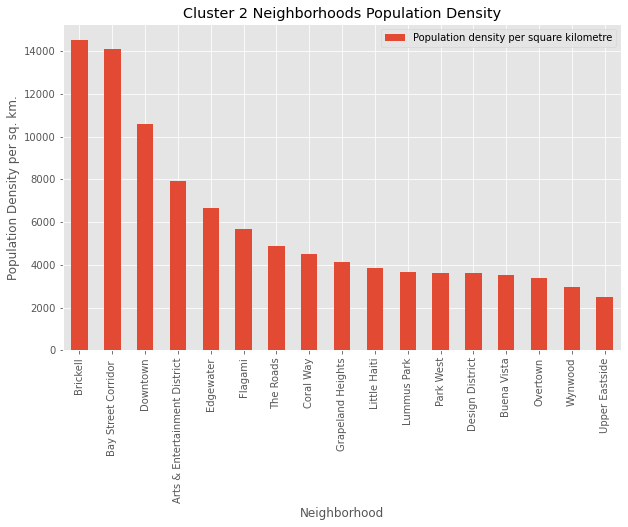

In [29]:
#Plot the neighborhoods in cluster #2 and their population density as a bar graph 
df_2_pd=df_2[['Neighborhood','Population density per square kilometre']]
df_2_pd.set_index('Neighborhood', inplace=True)

df_2_pd.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Population Density per sq. km.') # add y-label to the plot
plt.title('Cluster 2 Neighborhoods Population Density') # add title to the plot

plt.show()



In [46]:
#Create dataframe of just the top 5 venue categories for the Brickell Neighborhoods
df_brickellvenues=cities_merged[cities_merged['Neighborhood']=='Brickell']
df_venueplot=df_brickellvenues[['Hotel','Italian Restaurant','Japanese Restaurant','Argentinian Restaurant','Lounge']]


#Create dataframe of just the top 5 venue categories for the Bay Street Corridor Neighborhoods

df_bscvenues=(cities_merged.iloc[[21]])
df_bscvenues=df_bscvenues[['Coffee Shop', 'Italian Restaurant','Tea Room','Sushi Restaurant','Japanese Restaurant']]


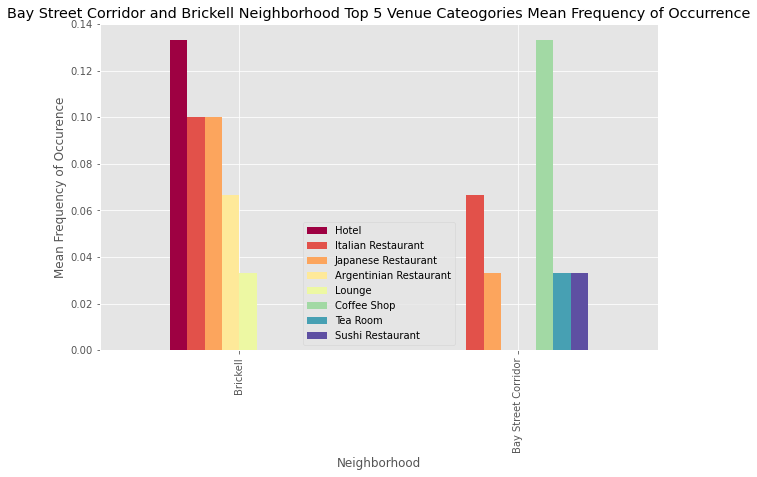

In [50]:


#Combine the Brickell and Bay Street Corridor Dataframes for top 5 vendor mean frequency of occurrences.
frames = [df_venueplot, df_bscvenues]

#concatenate dataframes
df_compare = pd.concat(frames, sort=False)
df_compare['Neighborhood']=('Brickell','Bay Street Corridor')
df_compare.set_index('Neighborhood', inplace=True, drop=True)
df_compare.replace(np.nan, 0, inplace=True)
df_compare
#Plot the data as a bar graph to compare the two neighborhoods.
df_compare.plot(kind='bar', figsize=(10, 6),colormap='Spectral')

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Mean Frequency of Occurence') # add y-label to the plot
plt.title('Bay Street Corridor and Brickell Neighborhood Top 5 Venue Cateogories Mean Frequency of Occurrence') # add title to the plot

plt.show()

### Conclusion: See report for full conclusion. The Brickell neighborhood is recommended as the neighborhood most similar to the Bay Street Corridor neighborhood, and so most suited to be the location of the next Chatime restaurant